# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities? 
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

In [25]:
# imports all necessary libraries 

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import root_mean_squared_error, r2_score


In [26]:
# import dataset
import pandas as pd

# clean data
df = pd.read_csv('./data/airbnb_hw.csv')
df.columns = df.columns.str.strip()
df['Price'] = df['Price'].replace('[\$,]', '', regex=True).astype(float)
df.head()

<>:7: SyntaxWarning: invalid escape sequence '\$'
<>:7: SyntaxWarning: invalid escape sequence '\$'
/var/folders/pm/fr4p6g5x33s7jjzlf3w9_hpm0000gn/T/ipykernel_69379/1382517976.py:7: SyntaxWarning: invalid escape sequence '\$'
  df['Price'] = df['Price'].replace('[\$,]', '', regex=True).astype(float)


,Host Id,Host Since,Name,Neighbourhood,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating
0,5162530,NaN,1 Bedroom in Prime Williamsburg,Brooklyn,Apartment,NaN,Entire home/apt,11249.0,1.0,1,0,145.0,NaN
1,33134899,NaN,"Sunny, Private room in Bushwick",Brooklyn,Apartment,NaN,Private room,11206.0,1.0,1,1,37.0,NaN
2,39608626,NaN,Sunny Room in Harlem,Manhattan,Apartment,NaN,Private room,10032.0,1.0,1,1,28.0,NaN
3,500,6/26/2008,Gorgeous 1 BR with Private Balcony,Manhattan,Apartment,NaN,Entire home/apt,10024.0,3.0,1,0,199.0,NaN
4,500,6/26/2008,Trendy Times Square Loft,Manhattan,Apartment,95.0,Private room,10036.0,3.0,1,39,549.0,96.0


In [27]:
# renamed and cleaned variable for easier handling in the formula
df = df.dropna(subset=["Price", "Room Type", "Number Of Reviews", "Beds", "Review Scores Rating"])
df.rename(columns={
    "Room Type": "RoomType",
    "Number Of Reviews": "NumberOfReviews",
    "Review Scores Rating": "ReviewScores"
}, inplace=True)

In [28]:
#2. transofrming the variable and dropping unneccessary columns
df["Log_Price"] = np.log1p(df["Price"])
df = pd.get_dummies(df, columns=["RoomType"], drop_first=True)
df.columns = df.columns.str.replace(" ", "_").str.replace("-", "_") 

drop_cols = ["Host_Id", "Host_Since", "Name", "Neighbourhood", "Zipcode",
             "Property_Type", "Review_Scores_Rating_(bin)", "Price"]
df = df.drop(columns=[col for col in drop_cols if col in df.columns])

In [29]:
#3. train test split
X = df.drop(columns=["Log_Price"])
y = df["Log_Price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
#4. simple linear model
lr = LinearRegression()
lr.fit(X_train, y_train)
train_pred = lr.predict(X_train)
test_pred = lr.predict(X_test)
print("Simple Linear Model:")
print("Train RMSE:", root_mean_squared_error(y_train, train_pred))
print("Test RMSE:", root_mean_squared_error(y_test, test_pred))
print("Train R²:", r2_score(y_train, train_pred))
print("Test R²:", r2_score(y_test, test_pred))
 

Simple Linear Model:
Train RMSE: 0.4068877905566234
Test RMSE: 0.41058666550656486
Train R²: 0.5066100923737178
Test R²: 0.5178221991266629


4. I built a simple linear regression model using the basic features with no transformations or interactions. It performed pretty well, with a train RMSE of 0.41 and test RMSE of 0.41, and an R² of about 0.52 on the test set. The similar train and test scores show the model isn’t overfitting and does a decent job explaining the variation in prices just using the original features.

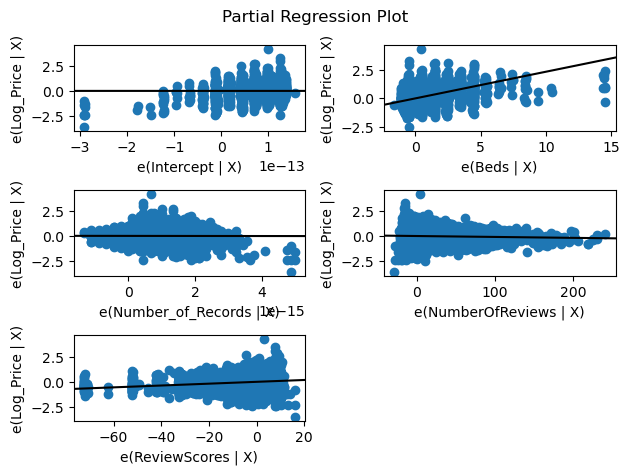

In [33]:
#5. Partial correlation plots
X_train_plot = X_train.copy()
X_train_plot["Log_Price"] = y_train
numeric_vars = X_train.select_dtypes(include=np.number).columns[:5]  # pick top 5 to avoid clutter
formula = "Log_Price ~ " + " + ".join(numeric_vars)
model = smf.ols(formula=formula, data=X_train_plot).fit()
fig = sm.graphics.plot_partregress_grid(model)
plt.tight_layout()
plt.show()

From the partial regression plots, there seems to be a slight curve in the relationship between Beds and Log_Price, which hints at some non-linearity. NumberOfReviews also shows a bit of a fan shape which could mean the effect changes at higher values. These patterns suggest that adding squared terms or interactions might help the model capture these effects better. 

In [34]:
#6. model with interactions 
X_train_c = X_train.copy()
X_test_c = X_test.copy()
X_train_c["Beds_squared"] = X_train_c["Beds"] ** 2
X_test_c["Beds_squared"] = X_test_c["Beds"] ** 2
X_train_c["Reviews_Beds"] = X_train_c["NumberOfReviews"] * X_train_c["Beds"]
X_test_c["Reviews_Beds"] = X_test_c["NumberOfReviews"] * X_test_c["Beds"]

lr_c = LinearRegression()
lr_c.fit(X_train_c, y_train)
train_pred_c = lr_c.predict(X_train_c)
test_pred_c = lr_c.predict(X_test_c)

print("\nComplex Model:")
print("Train RMSE:", root_mean_squared_error(y_train, train_pred_c))
print("Test RMSE:", root_mean_squared_error(y_test, test_pred_c))
print("Train R²:", r2_score(y_train, train_pred_c))
print("Test R²:", r2_score(y_test, test_pred_c))



Complex Model:
Train RMSE: 0.4057237600985583
Test RMSE: 0.4099400561004555
Train R²: 0.5094290482665296
Test R²: 0.5193397116269738


6. The complex model performed slightly better than the simple one with small improvement in both RMSE and R². The test RMSE went from 0.411 to 0.409, and test R² improved from 0.518 to 0.519. So while adding interaction and squared terms helped a bit, the gains were pretty minimal which tells us that the simple model was already doing a good job

7. Summary of the model:
I cleaned and transformed Airbnb data to see how listing features affect the price online. The simple model using basic features worked pretty well with no signs of overfitting. Partial plots showed some non-linear patterns so I added squared and interaction terms in a more complex model which slightly improved performance. This showed that while adding complexity can help it’s not always necessary if the base model already does a good job. 

In [36]:
#8 lasso regression 
lasso = LassoCV(cv=5, random_state=0)
lasso.fit(X_train_c, y_train)
lasso_pred_train = lasso.predict(X_train_c)
lasso_pred_test = lasso.predict(X_test_c)

print("\nLasso Regression:")
print("Train RMSE:", root_mean_squared_error(y_train, lasso_pred_train))
print("Test RMSE:", root_mean_squared_error(y_test, lasso_pred_test))
print("Train R²:", r2_score(y_train, lasso_pred_train))
print("Test R²:", r2_score(y_test, lasso_pred_test))
print("Selected Features:", X_train_c.columns[lasso.coef_ != 0].tolist())


Lasso Regression:
Train RMSE: 0.40645798596979443
Test RMSE: 0.4109161121449155
Train R²: 0.5076518992198134
Test R²: 0.5170481087884582
Selected Features: ['Beds', 'NumberOfReviews', 'ReviewScores', 'RoomType_Private_room', 'RoomType_Shared_room', 'Beds_squared', 'Reviews_Beds']
